## SubCenter ArcFace training test on CASIA dataset using Mobilenet

In [ ]:
import os
import glob2
import pickle
import numpy as np
import tensorflow as tf
import sys
from tensorflow import keras

gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

import train, losses
import tensorflow_addons as tfa

data_basic_path = '/datasets/'
data_path = data_basic_path + 'faces_casia_112x112_folders'
eval_paths = [data_basic_path + ii for ii in ['faces_casia/lfw.bin', 'faces_casia/cfp_fp.bin', 'faces_casia/agedb_30.bin']]

train.print_buildin_models()

### Baseline

In [ ]:
""" Train typical `ArcFace` loss as baseline """
basic_model = train.buildin_models("mobilenet", dropout=0, emb_shape=256, output_layer='E')
tt = train.Train(data_path, save_path='TT_mobilenet_base_bs400.h5', eval_paths=eval_paths,
    basic_model=basic_model, model=None, lr_base=0.1, lr_decay=0.1, lr_decay_steps=[20, 30],
    batch_size=400, random_status=0, output_wd_multiply=1)

optimizer = tfa.optimizers.SGDW(learning_rate=0.1, weight_decay=5e-4, momentum=0.9)
sch = [
    {"loss": losses.ArcfaceLoss(scale=16), "epoch": 5, "optimizer": optimizer},
    {"loss": losses.ArcfaceLoss(scale=32), "epoch": 5},
    {"loss": losses.ArcfaceLoss(scale=64), "epoch": 40},
]
tt.train(sch, 0)

### SubCenter ArcFace

In [ ]:
""" First, Train with `loss_top_k = 3` """
basic_model = train.buildin_models("mobilenet", dropout=0, emb_shape=256, output_layer='E')
tt = train.Train(data_path, save_path='TT_mobilenet_topk_bs400.h5', eval_paths=eval_paths,
    basic_model=basic_model, model=None, lr_base=0.1, lr_decay=0.1, lr_decay_steps=[20, 30],
    batch_size=400, random_status=0, output_wd_multiply=1)

optimizer = tfa.optimizers.SGDW(learning_rate=0.1, weight_decay=5e-4, momentum=0.9)
sch = [
    {"loss": losses.ArcfaceLoss(scale=16), "epoch": 5, "optimizer": optimizer, "lossTopK": 3},
    {"loss": losses.ArcfaceLoss(scale=32), "epoch": 5, "lossTopK": 3},
    {"loss": losses.ArcfaceLoss(scale=64), "epoch": 40, "lossTopK": 3},
]
tt.train(sch, 0)

In [ ]:
""" Then drop non-dominant subcenters and high-confident noisy data, which is `>75 degrees` """
import data_drop_top_k
# data_drop_top_k.data_drop_top_k('./checkpoints/TT_mobilenet_topk_bs400.h5', '/datasets/faces_casia_112x112_folders/', limit=20)
new_data_path = data_drop_top_k.data_drop_top_k(tt.model, tt.data_path)

In [ ]:
""" Train with the new dataset again, this time `loss_top_k = 1` """
tt.reset_dataset(new_data_path)
optimizer = tfa.optimizers.SGDW(learning_rate=0.1, weight_decay=5e-4, momentum=0.9)
sch = [
    {"loss": losses.ArcfaceLoss(scale=16), "epoch": 5, "optimizer": optimizer},
    {"loss": losses.ArcfaceLoss(scale=32), "epoch": 5},
    {"loss": losses.ArcfaceLoss(scale=64), "epoch": 40},
]
tt.train(sch, 0)

### Train TopK 1 from BottleneckOnly

- Train with `initial_epoch = 0`, that `learning_rate` will be `[0.1, 0.01, 0.001]`

In [ ]:
data_path = 'faces_casia_112x112_folders_shuffle_topK3_deg75.pkl'
tt = train.Train(data_path, save_path='TT_mobilenet_topk1_BTNO_bs400.h5', eval_paths=eval_paths,
    basic_model='checkpoints/TT_mobilenet_topk_bs256_basic_agedb_30_epoch_35_0.874333.h5', model=None, lr_base=0.1, lr_decay=0.1, lr_decay_steps=[20, 30],
    batch_size=400, random_status=0, output_wd_multiply=1)
optimizer = tfa.optimizers.SGDW(learning_rate=0.1, weight_decay=5e-4, momentum=0.9)
sch = [
    {"loss": losses.ArcfaceLoss(scale=64), "epoch": 1, "bottleneckOnly": True, "optimizer": optimizer},
    {"loss": losses.ArcfaceLoss(scale=64), "epoch": 40},
]
tt.train(sch, 0)

- Train with `initial_epoch = 40`, that `learning_rate` will be `0.001`

In [ ]:
data_path = 'faces_casia_112x112_folders_shuffle_topK3_deg75.pkl'
tt = train.Train(data_path, save_path='TT_mobilenet_topk1_BTNO_init_E40_bs400.h5', eval_paths=eval_paths,
    basic_model='checkpoints/TT_mobilenet_topk_bs256_basic_agedb_30_epoch_35_0.874333.h5', model=None, lr_base=0.1, lr_decay=0.1, lr_decay_steps=[20, 30],
    batch_size=400, random_status=0, output_wd_multiply=1)
optimizer = tfa.optimizers.SGDW(learning_rate=0.1, weight_decay=5e-4, momentum=0.9)
sch = [
    {"loss": losses.ArcfaceLoss(scale=64), "epoch": 1, "bottleneckOnly": True, "optimizer": optimizer},
    {"loss": losses.ArcfaceLoss(scale=64), "epoch": 40},
]
tt.train(sch, 40)

### Result and Plot

| Scenario                                    | Max lfw    | Max cfp_fp | Max agedb_30 |
| ------------------------------------------- | ---------- | ---------- | ------------ |
| Baseline, topk 1                            | 0.9822     | 0.8694     | 0.8695       |
| TopK 3                                      | 0.9838     | **0.9044** | 0.8743       |
| TopK 3->1                                   | 0.9838     | 0.8960     | 0.8768       |
| TopK 3->1, bottleneckOnly, initial_epoch=0  | **0.9878** | 0.8920     | **0.8857**   |
| TopK 3->1, bottleneckOnly, initial_epoch=40 | 0.9835     | **0.9030** | 0.8763       |

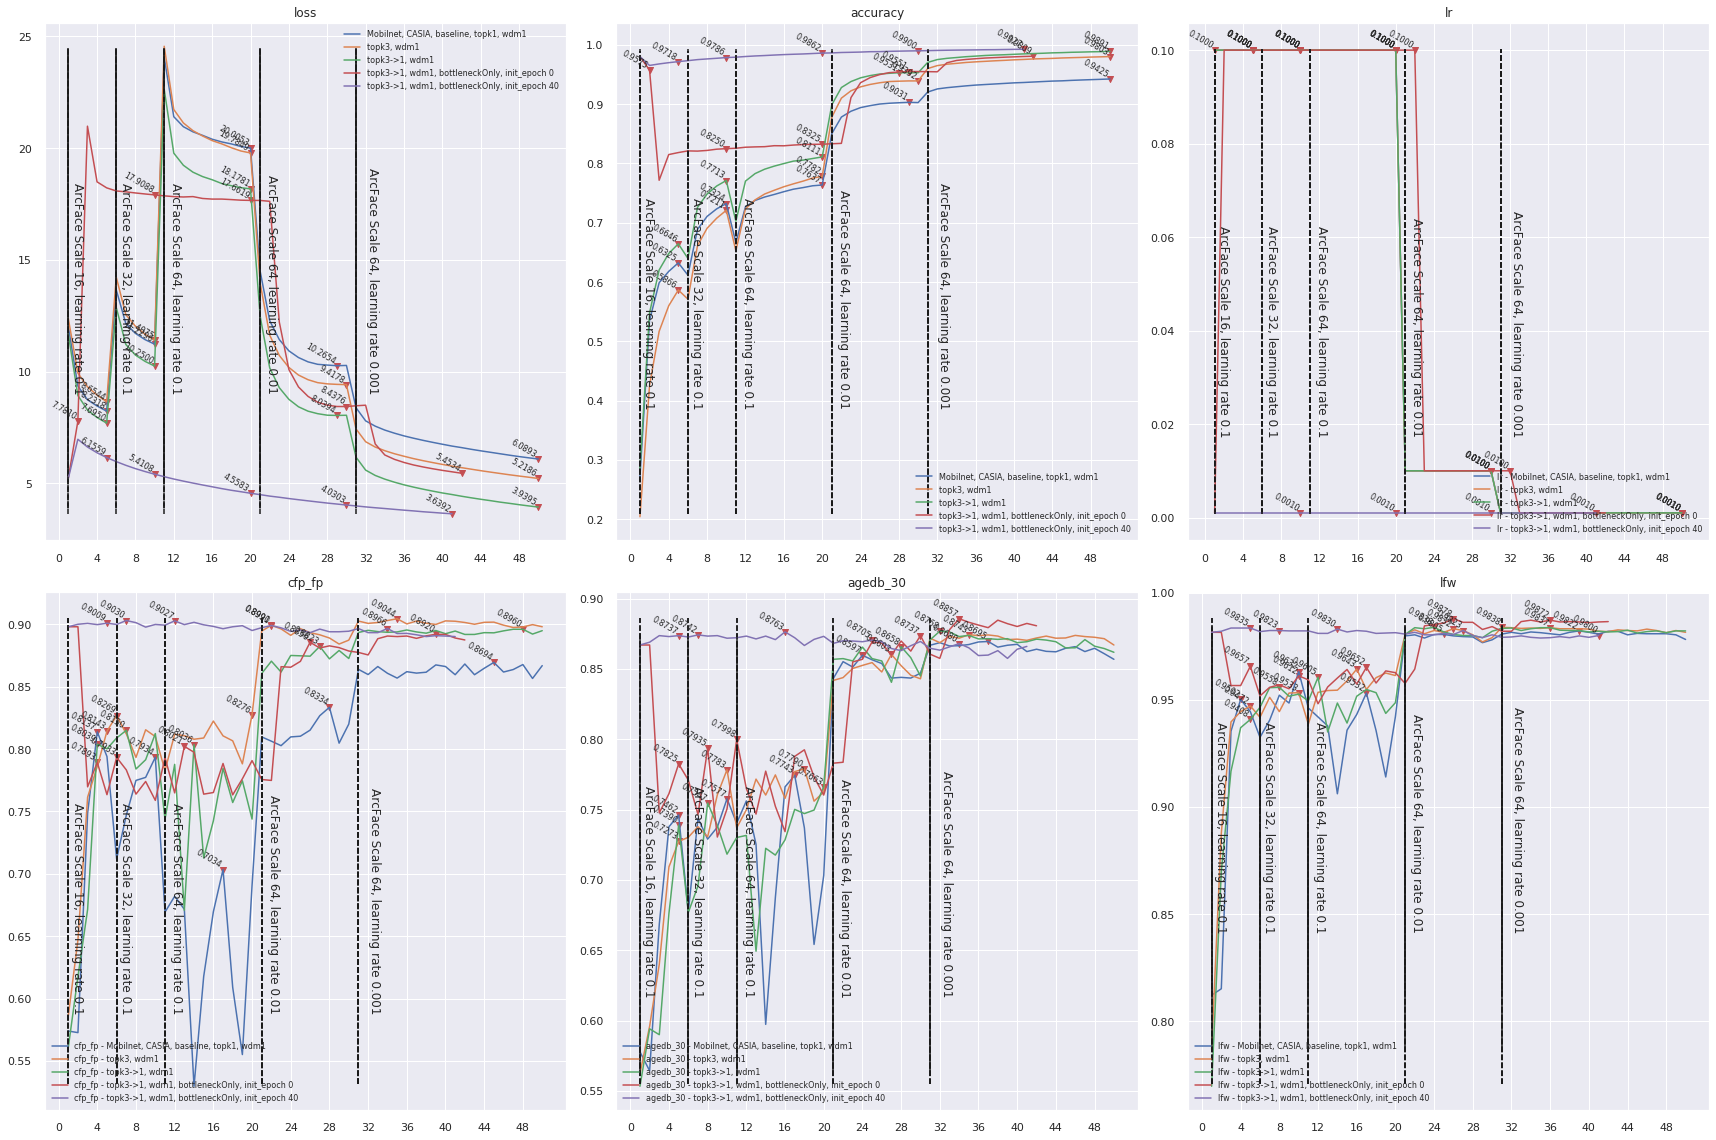

In [ ]:
import plot
axes = None
customs = ["cfp_fp", "agedb_30", "lfw", "lr"]
epochs = [5, 5, 10, 10, 40]
names = ["ArcFace Scale 16, learning rate 0.1", "ArcFace Scale 32, learning rate 0.1", "ArcFace Scale 64, learning rate 0.1", "ArcFace Scale 64, learning rate 0.01", "ArcFace Scale 64, learning rate 0.001"]
axes, _ = plot.hist_plot_split("checkpoints/TT_mobilenet_base_bs400_hist.json", epochs, axes=axes, customs=customs, names=names, fig_label='Mobilnet, CASIA, baseline, topk1, wdm1')
axes, pre = plot.hist_plot_split("checkpoints/TT_mobilenet_topk_bs400_hist.json", epochs, axes=axes, customs=customs, fig_label='topk3, wdm1')
axes, _ = plot.hist_plot_split("checkpoints/TT_mobilenet_topk1_bs400_hist.json", epochs, axes=axes, customs=customs, fig_label='topk3->1, wdm1')

axes, _ = plot.hist_plot_split("checkpoints/TT_mobilenet_topk1_BTNO_bs400_hist.json", epochs, axes=axes, customs=customs, pre_item=pre, fig_label='topk3->1, wdm1, bottleneckOnly, init_epoch 0')
axes, _ = plot.hist_plot_split("checkpoints/TT_mobilenet_topk1_BTNO_init_E40_bs400_hist.json", epochs, axes=axes, customs=customs, pre_item=pre, fig_label='topk3->1, wdm1, bottleneckOnly, init_epoch 40')